# Mini-Lab: Logistic Regression and SVMs

**Assignment Description**

You are to perform predictive analysis (classification) upon a data set:
model the dataset using methods we have discussed in class: 
logistic regression and support vector machines, and making conclusions from the analysis.
Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). 
This report is worth 10% of the final grade. 
You may complete this assignment in teams of as many as three people. 
Write a report covering all the steps of the project. 
The format of the document can be PDF, *.ipynb, or HTML. 

You can write the report in whatever format you like, but it is easiest to turn in the rendered iPython notebook.
The results should be reproducible using your report.

Please carefully describe every assumption and every step in your report.

____
### Table of Contents

    - Data Loading, Cleaning, Formatting, and Feature Selecting
        - Load the Data
        - Data Cleaning and Formatting
        - Data Feature Selection
        
**Create Models**

    - Model 1: Logistic Regression
        - Assumptions
            - Assumption 1
            - Assumption 2
            - Assumption 3
                - Variables with the highest correlation
                - Getting unique variable names for highest correlation
                - Variables with high income correlation
                - Removing variables with high correlation and low relative correlation with income
                - Variables to drop in decreasing order of importance 
                - Rechecking Correlations
                - Discussion of Multicollinearity Assumption
            - Assumption 4
            - Assumption 5
        - Influential Values
        - Dividing Data into Test-Train Split
        - Fitting The Logistic Regression Model

    - Model 2. Support Vector Machine
        - Model Selection and Assessment and Performance Metrics
        - GridSearchCV
        - SVM with Linear Kernel
        - Heuristics Hyperparamaters Tuning 
        - Evaluating SVM Test Performance


**Model Advantages**

**Interpret Feature Importance**

**Interpret Support Vectors**
____

### Data Loading, Cleaning, Formatting, and Feature Selecting

#### Load the Data

In [44]:
# Data Processing
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy import stats

# Data Visualization
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

# Code comparison
import time

# import dataset
df = pd.read_csv("cleanedAdultCensus.csv")

In [45]:
df.head()

,age,workclass,fnlwgt,education,educationNum,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,income,education_,jobtype
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K,HS,other
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,HS,private
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K,college,other
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,preHS,private
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,college,private


### Data Formatting

In [46]:
# I am dropping these because we have made other columns that capture the same information
df=df.drop(columns=['education', 'educationNum', 'workclass']) 
df.head()

,age,fnlwgt,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,income,education_,jobtype
0,90,77053,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K,HS,other
1,82,132870,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,HS,private
2,66,186061,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K,college,other
3,54,140359,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,preHS,private
4,41,264663,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,college,private


In [47]:
#adapted from https://stackoverflow.com/questions/23307301/replacing-column-values-in-a-pandas-dataframe
df.occupation.replace(['?'], ['occupation_other'], inplace=True)
df.nativeCountry.replace(['?'], ['native_country_other'], inplace=True)
df.income.replace(['<=50K'], [0], inplace=True)
df.income.replace(['>50K'], [1], inplace=True)
df.head()

,age,fnlwgt,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,income,education_,jobtype
0,90,77053,Widowed,occupation_other,Not-in-family,White,Female,0,4356,40,United-States,0,HS,other
1,82,132870,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,HS,private
2,66,186061,Widowed,occupation_other,Unmarried,Black,Female,0,4356,40,United-States,0,college,other
3,54,140359,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,preHS,private
4,41,264663,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,college,private


In [48]:
maybe_na = ["?"]
df.isin(maybe_na).sum()

age              0
fnlwgt           0
maritalStatus    0
occupation       0
relationship     0
race             0
sex              0
capitalGain      0
capitalLoss      0
hoursPerWeek     0
nativeCountry    0
income           0
education_       0
jobtype          0
dtype: int64

In [49]:
 categorical_columns=['maritalStatus', 'occupation', 'relationship', 'race', 'sex', 'nativeCountry', 'education_', 'jobtype']

In [50]:
for name in categorical_columns:
    
    #adapted from https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
    # Get one hot encoding of columns B
    one_hot = pd.get_dummies(df[name])
    # Drop column B as it is now encoded
    df = df.drop(name, axis = 1)
    # Join the encoded df
    df = df.join(one_hot)
    
df.head()  

,age,fnlwgt,capitalGain,capitalLoss,hoursPerWeek,income,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,...,Yugoslavia,native_country_other,HS,college,postGrad,preHS,entrepreneur,government,other,private
0,90,77053,0,4356,40,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,82,132870,0,4356,18,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,66,186061,0,4356,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,54,140359,0,3900,40,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,41,264663,0,3900,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [51]:
#list(df) # this prints all the features in the dataset

In [52]:
X= df.drop(columns=['income'])
y= df['income']

In [53]:
X.head()

,age,fnlwgt,capitalGain,capitalLoss,hoursPerWeek,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,...,Yugoslavia,native_country_other,HS,college,postGrad,preHS,entrepreneur,government,other,private
0,90,77053,0,4356,40,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,82,132870,0,4356,18,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,66,186061,0,4356,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,54,140359,0,3900,40,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,41,264663,0,3900,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [54]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: income, dtype: int64

# Create Models 

50 points

    Create a logistic regression model and a support vector machine model for the classification task involved with your dataset.  Assess how well each model performs (use 80/20 training/testing split for your data).  Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

## Model 1: Logistic Regression

### Assumptions

#### Assumption 1

"First, binary logistic regression requires the dependent variable to be binary and ordinal logistic regression requires the dependent variable to be ordinal." [stats solutions](https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

     The dependent variable is binary. 

#### Assumption 2
"Second, logistic regression requires the observations to be independent of each other.  In other words, the observations should not come from repeated measurements or matched data."  [stats solutions](https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

    There may be some lack of independence in the data because we may have multiple observations from the same household or same town. We can assume geographic relation may have some degree of statistical dependence. However, since there is nothing to do about this with our present tool kit we will just have to be aware of some bias in the data. 

#### Assumption 3

"Third, logistic regression requires there to be little or no multicollinearity among the independent variables.  This means that the independent variables should not be too highly correlated with each other."
[stats solutions](https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

#### Variables with the highest correlation

In [55]:
# Code adapted from https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr = X.corr()
c = corr.abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
print(so[7960:8008:2])
high_corr = so[7960:8008:2]

private             other                   0.373022
college             preHS                   0.373359
Own-child           Married-civ-spouse      0.380070
United-States       native_country_other    0.396016
Asian-Pac-Islander  Philippines             0.408355
Mexico              United-States           0.416286
Male                Married-civ-spouse      0.431805
Married-civ-spouse  Male                    0.431805
age                 Own-child               0.432918
Asian-Pac-Islander  White                   0.439572
Not-in-family       Husband                 0.482936
Never-married       Own-child               0.509226
age                 Never-married           0.534359
Married-civ-spouse  Not-in-family           0.537588
private             entrepreneur            0.539523
Husband             Never-married           0.576730
Male                Husband                 0.580135
Female              Husband                 0.580135
government          private                 0.

#### Getting unique variable names for highest correlation

In [56]:
all_high_corr_labels = []

#print(high_corr.index.tolist())
labels = high_corr.index.tolist()
for tuple_ in labels:
    all_high_corr_labels.append(tuple_[0])
    all_high_corr_labels.append(tuple_[1])

unique_high_corr_labels = list(set(all_high_corr_labels))
print(unique_high_corr_labels)

['Philippines', 'Female', 'United-States', 'college', 'Husband', 'HS', 'occupation_other', 'Own-child', 'White', 'other', 'Male', 'Not-in-family', 'Never-married', 'entrepreneur', 'native_country_other', 'private', 'government', 'Mexico', 'preHS', 'age', 'Asian-Pac-Islander', 'Black', 'Married-civ-spouse']


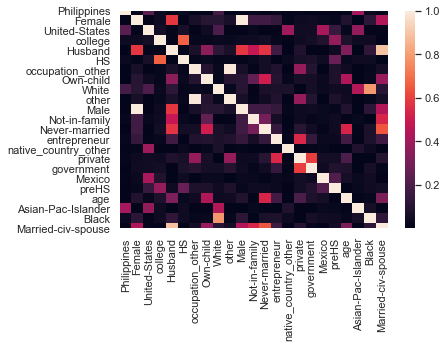

In [57]:
high_corr_map = abs(X[unique_high_corr_labels].corr())

sns.heatmap(high_corr_map, 
        xticklabels=high_corr_map.columns,
        yticklabels=high_corr_map.columns)

#### Variables with high income correlation

In [58]:
corr_features_to_check = unique_high_corr_labels.copy()
corr_features_to_check.append('income')
#print(corr_features_to_check)
high_correlation_suspects = df[corr_features_to_check]
all_corr_with_income = high_correlation_suspects.corr()
corr_with_income = abs(all_corr_with_income['income']).sort_values(kind="quicksort")
print(corr_with_income[15:24])

Not-in-family         0.188497
Male                  0.215980
Female                0.215980
Own-child             0.228532
age                   0.234037
Never-married         0.318440
Husband               0.401035
Married-civ-spouse    0.444696
income                1.000000
Name: income, dtype: float64


#### Removing variables with high correlation and low relative correlation with income

    Here the variables with high correlation are being removed. If there is a choice between two 
    variables to remove, the variable with the lower correlation with income is being taken out.  

In [59]:
#print(corr_with_income[15:24])
print(corr_with_income)
print()
print(high_corr)
print()
#print(unique_high_corr_labels)

native_country_other    0.003038
Asian-Pac-Islander      0.010543
Philippines             0.012306
United-States           0.034470
government              0.061903
Mexico                  0.062901
private                 0.078528
occupation_other        0.078583
other                   0.079348
White                   0.085224
Black                   0.089089
entrepreneur            0.105861
college                 0.126975
HS                      0.131189
preHS                   0.166292
Not-in-family           0.188497
Male                    0.215980
Female                  0.215980
Own-child               0.228532
age                     0.234037
Never-married           0.318440
Husband                 0.401035
Married-civ-spouse      0.444696
income                  1.000000
Name: income, dtype: float64

private             other                   0.373022
college             preHS                   0.373359
Own-child           Married-civ-spouse      0.380070
United-States      

#### Variables to drop in decreasing order of importance 

    Husband, other, White, college, never-married, 
    government, Female, private, not-in-family, 
    age, United-States, Asian-Pac-Islander, native_country_other,  

#### Rechecking Correlations

In [60]:
# Code adapted from https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

'occupation_other',  'Mexico', 'Married-civ-spouse', 
'entrepreneur', 'HS',  'other', 
'Black', 'Male', 'Philippines', 
'preHS', 'Own-child', 

X = X.drop(columns = ['Husband', 'other', 'White', 'college', 'Never-married',
'government', 'Female', 'private', 'Not-in-family', 
'age', 'United-States', 'Asian-Pac-Islander', 'native_country_other'])

corr = X.corr()
c = corr.abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
print("Correlation between variables \n")
print(so[5820:5852:2])
print(X.shape)

Correlation between variables 

Prof-specialty      HS                    0.217372
Craft-repair        Male                  0.223128
Male                Divorced              0.228621
                    hoursPerWeek          0.229309
Married-civ-spouse  Wife                  0.240279
hoursPerWeek        Own-child             0.249254
Adm-clerical        Male                  0.263148
HS                  preHS                 0.267427
Married-civ-spouse  Unmarried             0.317487
Male                Wife                  0.319311
                    Unmarried             0.321273
Divorced            Unmarried             0.328876
postGrad            Prof-specialty        0.332672
Married-civ-spouse  Divorced              0.366837
Own-child           Married-civ-spouse    0.380070
Married-civ-spouse  Male                  0.431805
dtype: float64
(32561, 77)


#### Discussion of Multicollinearity Assumption

As we can see directly above the majority of the multicollinearity has been removed. This is sufficient to run a logistic regression model. [motivation](https://stats.stackexchange.com/questions/87749/when-correlation-turns-too-high)

#### Assumption 4

"Fourth, logistic regression assumes linearity of independent variables and log odds.  although this analysis does not require the dependent and independent variables to be related linearly, it requires that the independent variables are linearly related to the log odds."
[stats solutions](https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

    Most of our variables are categorical and cannot be checked for linearity.[1] The continuous variables in our study are age, fnlwgt, capitalGain, captialLoss, and hoursPerWeek. We want to see a straight line or an S-shape.[2][3] All of our continuous variables as shown below meet this standard. 
    
sources: [1](https://www.statalist.org/forums/forum/general-stata-discussion/general/1441699-linearity-to-logit-assumption-logistic-regression), [2](http://www.sthda.com/english/articles/36-classification-methods-essentials/148-logistic-regression-assumptions-and-diagnostics-in-r/), [3](https://pythonfordatascience.org/logistic-regression-python/)

Text(0.5, 1.0, 'Age Log Odds Linear Plot')

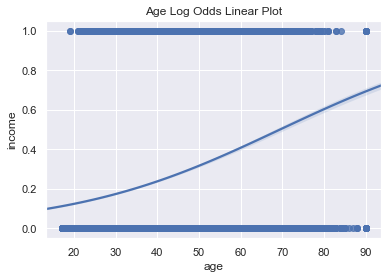

In [61]:
# code adapted from https://pythonfordatascience.org/logistic-regression-python/
sns.regplot(x= 'age', y= 'income', data= df, logistic= True).set_title("Age Log Odds Linear Plot")

Text(0.5, 1.0, 'fnlwgt Log Odds Linear Plot')

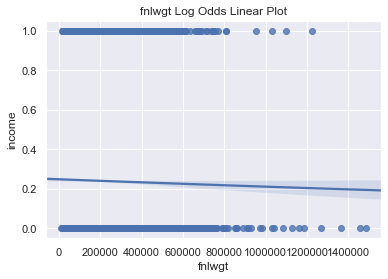

In [62]:
sns.regplot(x= 'fnlwgt', y= 'income', data= df, logistic= True).set_title("fnlwgt Log Odds Linear Plot")

Text(0.5, 1.0, 'capitalGain Log Odds Linear Plot')

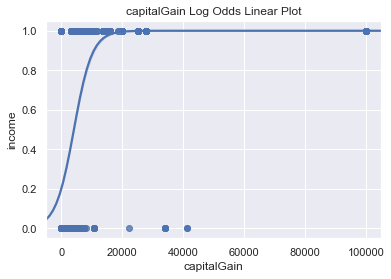

In [63]:
sns.regplot(x= 'capitalGain', y= 'income', data= df, logistic= True).set_title("capitalGain Log Odds Linear Plot")

Text(0.5, 1.0, 'capitalLoss Log Odds Linear Plot')

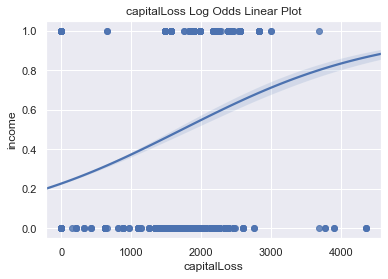

In [64]:
sns.regplot(x= 'capitalLoss', y= 'income', data= df, logistic= True).set_title("capitalLoss Log Odds Linear Plot")

Text(0.5, 1.0, 'hoursPerWeek Log Odds Linear Plot')

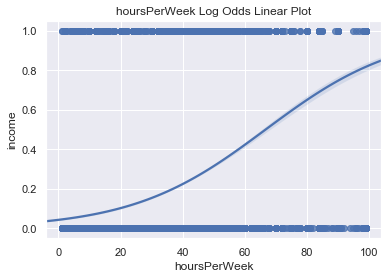

In [65]:
sns.regplot(x= 'hoursPerWeek', y= 'income', data= df, logistic= True).set_title("hoursPerWeek Log Odds Linear Plot")

#### Assumption 5

"Finally, logistic regression typically requires a large sample size. A general guideline is that you need at minimum of 10 cases with the least frequent outcome for each independent variable in your model. For example, if you have 5 independent variables and the expected probability of your least frequent outcome is .10, then you would need a minimum sample size of 500 (10*5 / .10)."
[stats solutions](https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

In [66]:
def minimum_number_of_samples(number_of_classes, probability_of_least_frequent_outcome):
    min_sample_count = (10*number_of_classes)/probability_of_least_frequent_outcome
    return min_sample_count

In [67]:
dataset_length = y.shape[0]
probability_of_least_frequent_outcome = np.sum(y)/dataset_length
number_of_classes = 2

minimum_samples = minimum_number_of_samples(number_of_classes, probability_of_least_frequent_outcome)

print("The the minimum number of samples we need is %d." %(minimum_samples))
print("Dataset length   %d" %(dataset_length))

The the minimum number of samples we need is 83.
Dataset length   32561


As we can see the maximum number of samples we need to run this analysis is 83. The number of samples in our dataset is 32561. So we have more than enough sample in order to run logistic regression.

#### Dividing Data into Test-Train Split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [69]:
X_train.head()

,fnlwgt,capitalGain,capitalLoss,hoursPerWeek,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Separated,Widowed,...,South,Taiwan,Thailand,Trinadad&Tobago,Vietnam,Yugoslavia,HS,postGrad,preHS,entrepreneur
5514,256263,0,0,25,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19777,170277,0,0,35,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10781,75826,0,0,40,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32240,24395,0,0,20,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9876,356689,0,0,40,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
y_train.head()

5514     0
19777    0
10781    0
32240    0
9876     0
Name: income, dtype: int64

#### Fitting The Logistic Regression Model

In [71]:
#adapted from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#LR = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0,
# fit_intercept=True, intercept_scaling=1, class_weight=None,
# random_state=None, solver='lbfgs', max_iter=100, multi_class='auto',
# verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

start_time = time.time()
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print("Training Accuracy: ", clf.score(X_train, y_train))
print("Testing Accuracy: ", clf.score(X_test, y_test))
print("\n--- Logistic Regression Model Run and Test time: %s seconds ---" % (time.time() - start_time))


weights = clf.coef_[0]
# print("Model weights: ", weights)
# print(type(weights))
# print(weights.items())

parameters = clf.get_params()

#print(type(parameters))
#print(parameters.items())


Training Accuracy:  0.7967982186732187
Testing Accuracy:  0.797328420082911

--- Logistic Regression Model Run and Test time: 0.24670195579528809 seconds ---


## Model 2. Support Vector Machine

In [18]:
#https://etav.github.io/python/vif_factor_python.html
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_corr = df.corr()
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif["features"] = df.columns
vif["Perason_correlation"] = df_corr["income"].values
print("Variance Inflation Factor and Perason correlation for Predictors on income")
vif.round(3).sort_values(by=['Perason_correlation'],ascending=False)


Variance Inflation Factor and Perason correlation for Predictors on income


,VIF Factor,features,Perason_correlation
4,1.785,income,1.000
8,3.118,isHusband,0.401
2,15.102,educationNum,0.335
0,8.585,age,0.234
3,11.430,hoursPerWeek,0.230
10,4.600,sex_Male,0.216
5,1.075,netCapital,0.214
6,6.952,isWhite,0.085
11,2.060,jobtype_government,0.062
9,9.361,USA,0.034


__Analysis__ after several iterations of performing the Variance Inflation Factor calcuation and review the results, above is the final output. The core variables removed all together or re-categoriezed were `race, maritalStatus, relationship, nativeCountry` as many of the variables had high variance inflation values. Therefore, some of these variables had to be removed or re-categoried in to new features as the variables would pose high risk of multicolinarity in explaining the features in the dataset in solving this classificaiton problem. 

### Model Selection and Assessment and Performance Metrics

This section we define the model training selection process. Since this is a binary classification problem the two core models we seek to evaluate are __Logistic Regression Models__ and __Support Vector Machine Models__.

* __Model Selection__ - the best models are determined based on the estimated performances when compared to related models. 
* __Performance Metrics__ - since the value of this classification problem is to determine whether income >50k, decision makers are looking for accurate probailities. Therefore, models are scored based on AUC_ROC
* __Random Partition__ - the data is split in to test and train with a 20/80 ratio, respectively. 

In [34]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Next we seek to train a model using the __Support Vector Machine (SVM)__ to compare ho well these supervised learning methods can best solve this classificaiton problem. We will be utilzing various SVM kernel functions such as `SVC` and `LinearSVC` kernerls to assist in the model training computation in finding the appropriate hyperplane for the classification to make a decision as to whether a given individual's income is greater or less than 50K. 

Use cost of error imporved with the parameter `class_weight` to adjust the weights more heavier on those that do not earn income >50K which is automatically adjusted. 

__General References__
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
* http://cs229.stanford.edu/notes/cs229-notes3.pdf


First we train SVM using the __Support Vector Classifier (SVC)__ kernel with classification valuation `C` = 1 which is the default parameter. 

In [128]:
y.value_counts()

0    24720
1     7841
Name: income, dtype: int64

Data is imbalanced, use `roc_auc` metric to accout for this. The __ROC Curve__ provides an objective way of scoring the models to select the best modesl that represents the area most under the curve. Specifically, using the ROC Cure as the scoring feature we can evaluate the model that provides the highest True Positive Rate for a given False Positive Rate. See __ROC Curve__ section below for further details. 

In [86]:
from sklearn.svm import SVC
start = time.time()
svc = SVC(class_weight='balanced')
svc.fit(X_train, y_train)
end = time.time()
print("Model Training Time="+str(end-start)+"s")

print('SVM Traning accuracy: {:.3f}'.format(accuracy_score(y_train, svc.predict(X_train))))
print('SVM test accuracy: {:.3f}'.format(accuracy_score(y_test, svc.predict(X_test))))


C:\Users\phhale\AppData\Local\Continuum\anaconda3\envs\bril\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model Training Time=106.80650854110718s
SVM Traning accuracy: 0.841
SVM test accuracy: 0.809


Before beginning SVC, we first scale the data to normalize it. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
start = time.time()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Now we can actually fit the support vector machine. 

In [69]:
from sklearn.preprocessing import MinMaxScaler
start = time.time()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

svc = SVC()
svc.fit(X_train_scaled, y_train)
end = time.time()
print("Model Training Time="+str(end-start)+"s")

print("SVM - Scaler Training accuracy:  {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("SVM - Scaler Testing accuracy:  {:.3f}".format(svc.score(X_test_scaled, y_test)))

Model Training Time=14.042011737823486s
SVM - Scaler Training accuracy:  0.827
SVM - Scaler Testing accuracy:  0.824


Here the results are show where the Training dataset accuracy is 82.7% and the test dataset accuracy is 82.4%. We can see that the default SVC kernel aided in not overfitting this dataset. 

### GridSearchCV

__Grid Search__ is utilize in this section for tuning the hyperparameters. "The method is to divide the space of possible hyperparameter values into regular intervals (a grid), train your model for all values on the grid, sequentially or preferably in parallel, and choose the best performing one."

_Source: from Bergstra & Bengio’s “Random Search for Hyper-Parameter Optimization”: https://www.quora.com/What-methods-do-you-prefer-when-performing-hyperparameter-optimization#_

Since the data is slightly skewed to having more <50k than >50k, __k-fold cross validation__ is utilized to split the data for effective sample use. 

In [88]:
from sklearn.model_selection import GridSearchCV

start = time.time()
clf = SVC()
param_grid = [{'kernel':['rbf'],'gamma':[50,5,10,0.5],
             'C':[10,0.1,0.001] }]
gsv = GridSearchCV(clf,param_grid,cv=5,n_jobs=-1)
gsv.fit(X_train_scaled, y_train)
end = time.time()
print("Time required ="+str(end-start)+"s")

Time required =1673.6280579566956s


In [89]:
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
Best Accuracy: 83.85%


In [97]:
# Testing Accuracy for best GriSearchCV SVM + Hyperparameters
start = time.time()
gsv_classifier = SVC(C = 10,kernel='rbf', gamma=0.5)
gsv_classifier = gsv_classifier.fit(X_train_scaled, y_train)
gsv_classifier_test_accuracy = gsv_classifier.score(X_test_scaled, y_test)
end = time.time()

print("Test Accuracy:  {:.3f}".format(gsv_classifier_test_accuracy))
print("Model Training Time="+str(end-start)+"s")

Test Accuracy:  0.836
Model Training Time=18.30422019958496s


Further improvement we see with the hyperparameter tuning for the `rbf` kernel, whilse training time is a bit higher, the accuracy improved for the test dataset including the scalled data from not tuning the hyperparameters. 

In [ ]:
"./dev/media/ROC_curve_explained.jpg"

### SVM with Linear Kernel

For this section, we are going to explore the `GridSearchCV` on the linear kernel. We are updating the model by:
1. specifying `predictions=True` to the models make predictions to optimize the scoring function. 
2. calling `scoring=roc_auc` which sets the scoring parameter to be optimized by the ROC curves



In [109]:
param_grid = [{'kernel':['linear'],'C':[10,0.1,0.001] }]
model = SVC(random_state=0, probability=True, kernel="linear")
grid = GridSearchCV(cv=4, estimator=model, param_grid=param_grid,scoring='roc_auc' ,n_jobs=-1)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([   1,   10,  100, 1000], dtype=int32)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [110]:
print(grid.best_score_)
print(grid.best_estimator_.C)

0.8656017405279218
1


In [135]:
grid.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [134]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, grid.predict_proba(X_test_scaled)[:,1])

0.8647667096827268

In [137]:
# Form a prediction set
predictions = grid.predict(X_test_scaled)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      4966
           1       0.73      0.47      0.57      1547

   micro avg       0.83      0.83      0.83      6513
   macro avg       0.79      0.71      0.74      6513
weighted avg       0.82      0.83      0.82      6513



In [116]:
# Testing Accuracy for best GridSearchCV SVM + Hyperparameters
start = time.time()
gsv_classifier = SVC(C = 1,kernel='linear', random_state=0, probability=True)
gsv_classifier = gsv_classifier.fit(X_train_scaled, y_train)
gsv_classifier_test_accuracy = gsv_classifier.score(X_test_scaled, y_test)
end = time.time()

print("Test Accuracy:  {:.3f}".format(gsv_classifier_test_accuracy))
print("Model Training Time="+str(end-start)+"s")


Test Accuracy:  0.833
Model Training Time=65.35101842880249s


In [130]:
gsv_classifier

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [138]:
# Form a prediction set
predictions = gsv_classifier.predict(X_test_scaled)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      4966
           1       0.73      0.47      0.57      1547

   micro avg       0.83      0.83      0.83      6513
   macro avg       0.79      0.71      0.74      6513
weighted avg       0.82      0.83      0.82      6513



__Analysis:__ Above we can see that features: `netCapital`, `educationNum`, `hoursPerWeek` and `age` all are indicated as contributing the most from an absolute values persective.  

#### Heuristics Hyperparamaters Tuning 
__Objective: utilize RandomizedSearchCV + Pipeline Scaling and Hyperparameters for computing model parameters__

Now that we have a good basis of the SVM model training and evaluations, the next step is to __tune hyper-parameter settings using hyristics__. To do this we will utilize `RandomizedSearchCV` function for finding the right model settins for each of the kernels. The main reason for selecting `RandomizedSearchCV` over the `GridSearchCV` which was used in the previous section to tune the hyper-parameters, `RandomizedSearchCV` provides addiitonal capabilities by randomly drawing samples from high-dimentioal spaces.

![](./media/hyperparameter_tuning.png)

_Source: from Bergstra & Bengio’s “Random Search for Hyper-Parameter Optimization”: https://www.quora.com/What-methods-do-you-prefer-when-performing-hyperparameter-optimization#_

This consit of:

* Classifier estimator
* heuristically calculating the parameter space using `scipy` for scaling the `gamma` and `C` parameters
* scaling the features
* calling the `RandomizedSearchCV` class for searching
* using `auc` as the scoring function

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,ParameterGrid, RandomizedSearchCV

pipeline = Pipeline([('scaler', StandardScaler()), ('cls', SVC())])

param_grid = {'cls__kernel':['rbf','linear'],
               'cls__gamma':scipy.stats.expon(scale=.1),
               'cls__C':scipy.stats.expon(scale=100)}


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

#Grid Search Cross Validation
start = time.time()
grid = RandomizedSearchCV(estimator=pipeline,
                    param_distributions=param_grid, cv=5,
                    n_jobs=-1,
                    verbose=1,
                    n_iter=12, 
                    scoring='roc_auc')

grid.fit(X_train, y_train)

print ("score = %3.2f" %(grid.score(X_test,y_test)))

print (grid.best_params_)
end = time.time()

print("Model Training Time="+str(end-start))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 80.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 151.1min finished
C:\Users\phhale\AppData\Local\Continuum\anaconda3\envs\bril\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\phhale\AppData\Local\Continuum\anaconda3\envs\bril\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\phhale\AppData\Local\Continuum\anaconda3\envs\bril\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


score = 0.86
{'cls__C': 101.72732797426653, 'cls__gamma': 0.028575165238233047, 'cls__kernel': 'rbf'}
Model Training Time=9104.226702451706


In [38]:
print("Best HyperParameter: ",grid.best_params_)
print("Best Training Accuracy:  {:.3f}".format(max(grid.cv_results_['mean_train_score'])))
print("Best Validaton Accuracy:  {:.3f}".format(grid.best_score_))

Best HyperParameter:  {'cls__C': 101.72732797426653, 'cls__gamma': 0.028575165238233047, 'cls__kernel': 'rbf'}
Best Training Accuracy:  0.933
Best Validaton Accuracy:  0.866


C:\Users\phhale\AppData\Local\Continuum\anaconda3\envs\bril\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [42]:
print(grid.cv_results_)

{'mean_fit_time': array([  62.38044968,  343.38500376,  714.89777608, 1723.89832621,
        112.56369162,  292.41214609,   53.1122869 ,   66.54744577,
        529.03328567,   34.03668694, 2324.68767872,  767.10599933]), 'std_fit_time': array([  2.5582011 ,  33.49924713, 336.45200934, 230.39925756,
         3.73251797,  20.87450816,   2.81123085,   1.89038168,
        60.33090824,   2.40893274, 248.87466057,  70.02859489]), 'mean_score_time': array([2.61195927, 1.64991479, 1.77158689, 1.82206416, 2.26646161,
       2.48506541, 2.95745935, 2.94633579, 1.59529896, 3.13397446,
       1.351473  , 1.24487615]), 'std_score_time': array([0.24500231, 0.3115881 , 0.37488002, 0.41708028, 0.18972155,
       0.43015104, 0.31698935, 0.38668443, 0.18490076, 0.63171615,
       0.28727436, 0.40276488]), 'param_cls__C': masked_array(data=[50.69050069568315, 50.62461257096801,
                   75.78998415749798, 283.2844345297639,
                   324.4114506633554, 247.3491124398386,
              

In [43]:
rbf_gsv_grid = grid
rbf_gsv_grid.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('cls', SVC(C=101.72732797426653, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.028575165238233047,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [45]:
rbf_gsv_grid.best_params_['cls__C']

'rbf'

In [48]:
from sklearn.metrics import classification_report
# Form a prediction set
rbf_gsv_grid_predictions = rbf_gsv_grid.predict(X_test)

# Print a classification report
print(classification_report(y_test,rbf_gsv_grid_predictions))

C:\Users\phhale\AppData\Local\Continuum\anaconda3\envs\bril\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4966
           1       0.77      0.48      0.59      1547

   micro avg       0.84      0.84      0.84      6513
   macro avg       0.81      0.72      0.75      6513
weighted avg       0.83      0.84      0.83      6513



#### Evaluating SVM Test Performance

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
# Model Configs

test_eval_pipelines = []
test_eval_pipelines.append(('Linear_SVM', Pipeline([('Scaler', StandardScaler()),('Linear_SVM', SVC(random_state=0, probability=True,
                                                                                          kernel="linear",
                                                                                          C=1))])))
test_eval_pipelines.append(('RBF_SVM', Pipeline([('Scaler', StandardScaler()),('RBF_SVM', SVC(random_state=0, probability=True,
                                                                                    kernel="rbf", 
                                                                                    C=rbf_gsv_grid.best_params_['cls__C'], 
                                                                                    gamma=rbf_gsv_grid.best_params_['cls__gamma']))])))

# https://github.com/benhhu/HDSMeetup/blob/6dec21eb2a2fdc9a85e0c856618f280f83c147aa/11072016SVM_classification.ipynb
# Make predictions on test dataset
test_results = []
names = []
for name, model in test_eval_pipelines:
    model.fit(X_train,y_train)
    fpr, tpr, thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])
    result = auc(fpr,tpr)
    test_results.append(result)
    names.append(name)
    msg = "%s: %f" % (name, result)
    print(msg)


C:\Users\phhale\AppData\Local\Continuum\anaconda3\envs\bril\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\phhale\AppData\Local\Continuum\anaconda3\envs\bril\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


## Model Advantages

**10 points**

    Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy?  In terms of training time or efficiency?  Explain in detail.

Looking at the accuracy scores as an initial metric, we see that the logistic regression gives us an accuracy of 79.7%, the simple support vector machine gives us 80.9% accuracy, and the cross-validated grid search SVM gives an accuracy of 86% after tuning the hyperparameters. Judging solely by accuracy, it seems that grid search gives the best predictive results. 

Examining the confusion matrix shows that while the grid search displays strong precision for both high- and low-income individuals, as well as strong specificity for high-income individuals. However, the grid search model only correctly identifies less than 50% of low-income individuals as such. 

Overall, due to the higher accuracy scores and the strong precision/recall metrics, I would venture that the grid search model is the best of the three explored so far. Further improvements can be made in order to better boost that model's recall score. 

The logistic regression ran in the order of 10's of milliseconds. The SVM ran in the order of hours. In terms of training time. Logistic Regression by far out performs the SVM. However, if we are training a model where accuracy is very important and training time on the order of days is trivial then the SVM is the clear choice. 

## Interpret Feature Importance

**30 points**

     Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

The general equation for logistic regression is:

\begin{align}
log(p/(1-p)) = \beta_{0} + \beta_{1} * x_{1} + \beta_{2} * x_{2} + ... + \beta_{k} * x_{k}
\end{align}`

Each coefficient from the logistic regression is an indicator of how strongly the associated parameter is correlated with the logged odds ratio of the dependent variable - in this case, the odds a person makes over \$50k. 

The regression model from the sklearn package first normalizes all our variables into a uniform scale before regressing, using L2 regularization by default. Accordingly, we chose to not include an intercept term in our model given all our transformed numeric variables should have mean 0. 

In [38]:
# calculate p values: sklearn doesn't have a way to do this manually
# Code taken from rspeare, https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
class modified_logreg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self, linear_model):#,**kwargs):
        self.model = linear_model

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stats.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

In [41]:
wrapped_model = modified_logreg(clf)
wrapped_model.fit(X_train, y_train)
detailed_scores = {'Feature' : X_train.columns, 'coefficient' : weights, 'z_score' : wrapped_model.z_scores, 'p_values' : wrapped_model.p_values, 'sigma' : wrapped_model.sigma_estimates}
detailed_scores = pd.DataFrame(detailed_scores)
pd.set_option('display.max_rows', None)
detailed_scores

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Feature,coefficient,z_score,p_values,sigma
0,fnlwgt,-3.723875e-06,-2.023305e+01,5.010267e-91,1.840491e-07
1,capitalGain,3.277125e-04,3.085634e+01,4.605416e-209,1.062059e-05
2,capitalLoss,7.741590e-04,2.162925e+01,9.531523e-104,3.579222e-05
3,hoursPerWeek,-1.497369e-02,-1.008012e+01,6.764364e-24,1.485468e-03
4,Divorced,-4.460941e-04,-7.612464e-03,9.939262e-01,5.860049e-02
5,Married-AF-spouse,2.966808e-06,4.790588e-06,9.999962e-01,6.192994e-01
6,Married-civ-spouse,1.139852e-03,2.226878e-02,9.822335e-01,5.118611e-02
7,Married-spouse-absent,-4.420318e-05,-3.002339e-04,9.997604e-01,1.472291e-01
8,Separated,-1.059514e-04,-1.031785e-03,9.991768e-01,1.026874e-01
9,Widowed,-1.193443e-04,-1.171212e-03,9.990655e-01,1.018982e-01


Without considering sample sizes or significance values, looking at the regression weights, we see that the most strongly predictive features of an individual's income are his/her number of hours worked per week, marital status, and educational attainment. Looking at his/her hours worked per week for example, we see that an 50\% increase in an individual's working hours results in a 0.015\* 50 = .75\% decrease in his or her's log odds of making over \$50k, holding all other variables constant. This is a surprising trend - from EDA, we'd expect that people who work more are more likely to earn over 50 thousand. 

Just for fun, we fit a logistic model with hours per week as the only predictor. This time, we have a positive coefficient as expected - suggesting that we might be overfitting with the full model. 

In [60]:
# test a sample regression with only hours as a predictor
test_reg = LogisticRegression(random_state=0).fit(X_train[['hoursPerWeek']], y_train)
test_reg.coef_[0]

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.04419663])

Let's examine educational attainment in particular. We have 4 education bins - non high school grads, high school graduates, college graduates, and post-grad degree holders. Due to the way we one-hot encoded our dataset, we are using college grads as a reference level. In that case, holding all other variables constant our reduced logistic regression equation becomes:

\begin{align}
logit(p(Income > 50k)) = -.0005 * preHS -.0006 * HS + 0.00028 * postGrad
\end{align}

The regression equation tells us that relative to college graduates, pre-high school graduates and high school graduates have lower log odds of earning over \\$50k annually, and post-grad degree attainers have a higher log odds. For example, the odds of an individual earning over \$50k given a post-graduate degree is exp(.00028) = 1.00028 greater than an individual with a college degree. This is in line with what we expected in exploratory data analaysis.

In [40]:
detailed_scores[detailed_scores.Feature.isin(['preHS','HS', 'postGrad'])]

,Feature,coefficient,z_score,p_values,sigma
73,HS,-0.000645,-0.016104,0.987151,0.040033
74,postGrad,0.000281,0.003792,0.996974,0.074106
75,preHS,-0.000479,-0.008583,0.993152,0.055829


In [43]:
detailed_scores.sort_values(by='p_values')[['Feature', 'p_values']]

,Feature,p_values
1,capitalGain,4.605416e-209
2,capitalLoss,9.531523e-104
0,fnlwgt,5.010267e-91
3,hoursPerWeek,6.764364e-24
6,Married-civ-spouse,9.822335e-01
73,HS,9.871514e-01
26,Own-child,9.901506e-01
75,preHS,9.931517e-01
4,Divorced,9.939262e-01
27,Unmarried,9.951914e-01


Examining the p-values, we see a stark divide: all features are either significant at an infinitessimal alpha (alpha < 1e-24), or insignificant at any alpha < .98. Only the fnlwght, weekly hours worked, and capital gain/loss attributes are significant in our model. 

From EDA, we know that fnlwgt is more of a metadata feature than an actual explanatory feature. Additionally, the capital gain/loss attributes are distributed with an extreme right skew, such that most of the observations are at 0 and a few high-leverage outliers make up the bulk of the distribution. We will likely choose to not include fnlwgt in our final analysis, but the capital gain/loss attributes can be included if log transformed or summed to create a new attribute. 

We also expect from EDA that hours worked per week would be strongly correlated with income bracket. Our p-value confirms this, although the sign of the coefficient is not what we expect. 


## Interpret Support Vectors

**10 points**

    Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

We did not use any stochastic gradient descent - we solved for our SVC parameters deterministically. 

#### Feature Imporance

Only linear kernals have the capabilities to transform the feature vector where the input can be plotted for feature importance analysis. Below we call the `feature_importances` function to obtain the features coefficence and their ovrall importance in the model.  

In [36]:
from matplotlib import pyplot as plt

def feature_importances(coef, names):
    #https://stackoverflow.com/a/41601281
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

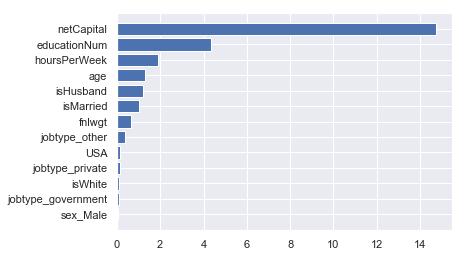

In [150]:
features_names = X_train.columns.to_list()
feature_importances(abs(gsv_classifier.coef_[0]), features_names)

We see that the SVM we trained identifies net capital, education attainment, hours worked per week, age, marriage status, and job status as the main features in predicting income bracket. Capital and hours worked are also significant predictors in our logistic regression model, so we can probably further assume that those variables should be included in any other model iterations. Age, education, and job type are also assumed to be significant given prior expectations about what these demographic indicators say about income. They are indeed prominent features in our SVM model, but the logistic regression model does not agree. 

### Evaluating Test Performance with ROC Curves

When evaluating the models scored off of the ROC Curves, we are interested in understanding that the best classification has the largest area under the curve. As described by Alaa tharwat in [Classification_Assessment_Methods_a_detailed_tutorial](https://www.researchgate.net/publication/327148996_Classification_Assessment_Methods_a_detailed_tutorial), 

> The __receiver operating characteristics (ROC) curve__ is a twodimensional graph in which the TPR represents the y-axis and FPR is the x-axis.  It is used to make a balance between the benefits, i.e., true positives, and costs, i.e., false positives. Any classifier that has discrete outputs such as decision trees is designed to produce only a class decision, i.e., a decision for each testing sample, and hence it generates only one confusion matrix which in turn corresponds to one point into the ROC space. However, there are many methods that were introduced for generating full ROC curve from a classifier instead of only a single point such as using class proportions or using some combinations of scoring and voting. 

![](./dev/media/ROC_curve_explained.jpg)

> The Above figure shows shows an example of the ROC curve. As shown, there are four important points in the ROC curve. The point A, in the lower left corner (0,0) represents a classifier where there is no positive classification, while all negative samples are correctly classified and hence TPR= 0 and FPR= 0. The point C, in the top right corner
(1,1), represents a classifier where all positive samples are correctly classified, while the negative samples are misclassified. The point D in the lower right corner (1,0) represents a classifier where all positive and negative samples are misclassified. The point B in the upper left corner (0,1) represents a classifier where
all positive and negative samples are correctly classified; thus, this point represents the perfect classification or the Ideal operating point. 

Therfore, we can utilize ROC Curves to evaluate the classification performance of the model. Ideally we will be looking, AT BEST the green line (B) which shows the "perfect classification", however, if we see such results, that model is subject to additional review for overtraining. As the "curve reflects that the classifier perfectly
ranked the positive samples relative to the negative samples.".

Source: Classification_Assessment_Methods_a_detailed_tutorial - https://www.researchgate.net/publication/327148996_Classification_Assessment_Methods_a_detailed_tutorial



In [100]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
# Model Configs

test_eval_pipelines = []
test_eval_pipelines.append(('Linear_SVM', Pipeline([('Scaler', StandardScaler()),('Linear_SVM', SVC(random_state=0, probability=True,
                                                                                          kernel="linear",
                                                                                          C=1))])))
test_eval_pipelines.append(('RBF_SVM', Pipeline([('Scaler', StandardScaler()),('RBF_SVM', SVC(random_state=0, probability=True,
                                                                                    kernel="rbf", 
                                                                                    C=rbf_gsv_grid.best_params_['cls__C'], 
                                                                                    gamma=rbf_gsv_grid.best_params_['cls__gamma']))])))

# https://github.com/benhhu/HDSMeetup/blob/6dec21eb2a2fdc9a85e0c856618f280f83c147aa/11072016SVM_classification.ipynb
# Make predictions on test dataset
test_results = []
auc_results = []
names = []
for name, model in test_eval_pipelines:
    start = time.time()
    model.fit(X_train,y_train)
    fpr, tpr, thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])
    end = time.time()
    rocauc_score = roc_auc_score(y_test, model.predict(X_test))
    auc_results.append([rocauc_score, fpr, tpr, thresholds])
    
    result = auc(fpr,tpr)
    test_results.append(result)
    names.append(name)
    msg = "%s: %f" % (name, result)
    print(msg)
    print("Model Processing Time="+str(end-start)+"s")
    print("classification report")
    print(classification_report(y_test,model.predict(X_test)))
    


Linear_SVM: 0.864156
Model Processing Time=88.17571949958801s
classification report
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      4966
           1       0.72      0.48      0.58      1547

   micro avg       0.83      0.83      0.83      6513
   macro avg       0.79      0.71      0.74      6513
weighted avg       0.82      0.83      0.82      6513

RBF_SVM: 0.863552
Model Processing Time=198.89919757843018s
classification report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4966
           1       0.77      0.48      0.59      1547

   micro avg       0.84      0.84      0.84      6513
   macro avg       0.81      0.72      0.75      6513
weighted avg       0.83      0.84      0.83      6513



__Analysis:__ __Recall__ and __Precision__ are the core metrics of interest in our evaluation and understanding of the model performance. Uses these we interpre thte results frmo the above confusion matrix. "Precision and the Recall will vary in the opposite direction. The higher the threshold, the higher the Precision and the lower the Recall. Similarly, the lower the threshold, the lower the Precision and the higher the Recall. The goal is to identify the threshold with the best balance between Precision and Recall." _source: [Looking at the Precision-Recall curve](https://towardsdatascience.com/the-proper-way-to-use-machine-learning-metrics-4803247a2578)_.

* __Recall (objectove: avoid false negatives)__ for the linear_SVM model we can see the recal score is 48%, which is hte same for the the `RBF_SVM` kernel. __We can interpret this as the SVM kernels were able to fined 48% of the individuals that had income >50K only 48% of the time.__ Both models have equal suprior in terms of recall. In the case of our classification problem this translates to the model being able to determine WHEN an individual makes >50k income, how often is the model predictions correct. Linear_SVM is more ideal as it was faster. 

* __Precision__ in the case of this binary classification problem, when the model predicts that an individual makes >50k, WILL that indiviually actuall make above that income. Here `RBF_SVM` (77%) slightly outperforms the Linear Kernel (72%). __We can interpret this as 77% of the time the `RBF_SVM` kernal model prediction were correct.__

Note, the Lienar kernel took half the amount of time than the RBF Kernel.  

Both model reported `f1-score` accuracy around ~59% which is higher than the 48% recall but lower than the ~77% precision score. However, from the begingin using the default SVC() kernals before hyperparameter tuning and scaling + CVSearch pipeline, the final models are handing the unbalanced classes with a higher accuracy. 

##### ROC Curve

Finally, we graph the ROC Curve from the 2 models. Below is an excellent graph of interpretining the ROC Curve posted by [Stephanie Glen on ROC Curve Explained in One Picture](https://www.datasciencecentral.com/profiles/blogs/roc-curve-explained-in-one-picture)

> With a ROC curve, you're trying to find a good model that optimizes the trade off between the False Positive Rate (FPR) and True Positive Rate (TPR).  What counts here is how much area is under the curve (Area under the Curve = AuC). The ideal curve in the left image fills in 100%, which means that you're going to be able to distinguish between negative results and positive results 100% of the time (which is almost impossible in real life). The further you go to the right, the worse the detection. The ROC curve to the far right does a worse job than chance, mixing up the negatives and positives (which means you likely have an error in your setup). 

>![](./dev/media/ROC_in_one_picture.png)

>[Stephanie Glen on ROC Curve Explained in One Picture](https://www.datasciencecentral.com/profiles/blogs/roc-curve-explained-in-one-picture)

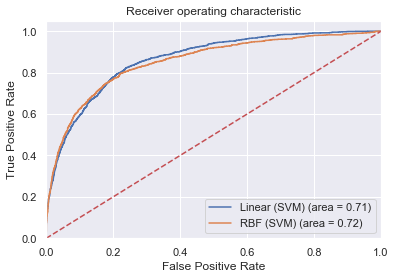

In [81]:
# https://github.com/naivelogic/Machine_Learning_Notebooks/blob/e0cf78b15c15f433d7d9d35dc7ad30cfe4d8cfda/Titanic%20Survival%20Prediction.ipynb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

linear_gsv_roc_auc = roc_auc_score(y_test, linear_gsv_classifier.predict(X_test_scaled))
linear_gsv_fpr, linear_gsv_tpr, linear_gsv_thresholds = roc_curve(y_test, linear_gsv_classifier.predict_proba(X_test_scaled)[:,1])

rbf_roc_auc = roc_auc_score(y_test, rbf_gsv_classifier_.predict(X_test_scaled))
rbf_fpr, rbf_tpr, rbf_thresholds = roc_curve(y_test, rbf_gsv_classifier_.predict_proba(X_test_scaled)[:,1])

plt.figure()
plt.plot(linear_gsv_fpr, linear_gsv_tpr, label='Linear (SVM) (area = %0.2f)' % linear_gsv_roc_auc)
plt.plot(rbf_fpr, rbf_tpr, label='RBF (SVM) (area = %0.2f)' % rbf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')

Above the the ROC cureve that show the AUC for the probability analaysis. Both cuvers are nice and round with the majorty leaning rate towards the 1.0.We can see both curves has generally similarly area under the curve providign indicaiton that both perform quite well across the board in classifying the Yes or No category as to if a given individual makes more than 50K income. The `Linear_SVM` kernel has just more area than the `RBF_SVM` kernal. 

When using the `Linear_SVM` kernel the main features that was highly important were `netCapital`, `education`, `hoursPerWeek`, `Age`. After the utilization of RandomSearch and Cross Validation on many different SVM kernels and hyper-parameters, the linear kernel computed the fastest with high AUC and ROC scores. 

The best kernel selected was the `RBF_SVM`. This model was just more supirior in Precision performing 77% accuracy in correct income prediction and a ROC score of 72%. 

---
# Appendix A - SVM

In [62]:
def svm_perprocessing():
    # import dataset
    df = pd.read_csv("../cleanedAdultCensus.csv")

    #  consolidate capital gain/loss into a single net metric.
    df['netCapital'] = df['capitalGain']  - df['capitalLoss']

    # create new variable categorizes worked hours per week
    df.loc[df.hoursPerWeek > 40, "workhrs_"] = "overtime"
    df.loc[(df.hoursPerWeek <= 40) & (df.hoursPerWeek >= 30), "workhrs_"] = "fulltime"
    df.loc[(df.hoursPerWeek < 30 ) & (df.hoursPerWeek >= 20), "workhrs_"] = "partime"
    df.loc[df.hoursPerWeek < 20, "workhrs_"] = "limited"

    #maritalStatus_old = {'Widowed': 'separate', 'Divorced': 'separate', 'Separated': 'separate', 'Never-married': 'single', 'Married-civ-spouse': 'married', 'Married-spouse-absent': 'a_other', 'Married-AF-spouse': 'a_other'}
    #maritalStatus_ = {'Widowed': 'single', 'Divorced': 'single', 'Separated': 'single', 'Never-married': 'single', 'Married-civ-spouse': 'married', 'Married-spouse-absent': 'a_other', 'Married-AF-spouse': 'a_other'}
    #df['maritalStatus_'] = df.maritalStatus.map(lambda x: maritalStatus_[x])

    # compute the nearest 10 for person's decade birth
    #df['age_decade'] = (df.age // 10) * 10

    # one-hot encode `income` and race and maritalStatus, relationship, nativeCountry
    df.loc[df.income == "<=50K", 'income'] = 0 
    df.loc[df.income == ">50K", 'income'] = 1

    df.loc[df.race == "White", 'isWhite'] = 1
    df.loc[df.race != "White", 'isWhite'] = 0

    df.loc[df.maritalStatus == 'Married-AF-spouse', 'isMarried'] = 1
    df.loc[df.maritalStatus != 'Married-AF-spouse', 'isMarried'] = 0

    df.loc[df.relationship == 'Husband', 'isHusband'] = 1
    df.loc[df.relationship != 'Husband', 'isHusband'] = 0

    df.loc[df.nativeCountry == 'United-States', 'USA'] = 1
    df.loc[df.nativeCountry != 'United-States', 'USA'] = 0


    # drop unneeded columns
    #'educationNum','hoursPerWeek',
    unneeded_columns = ['workclass', 'education', 'maritalStatus','race',
                        'occupation', 'capitalGain', 'capitalLoss', 'nativeCountry', 'relationship',
                       'education_','workhrs_']
    df.drop(unneeded_columns, axis=1, inplace=True)



    categorical_variables =  ['sex', 'jobtype' ]
    for var in categorical_variables:
        category_list = 'var'+'_'+var
        category_list = pd.get_dummies(df[var], prefix=var, drop_first=True)
        _temp = df.join(category_list)
        df = _temp


    df.drop(categorical_variables, axis=1, inplace=True)
    #df.head()

    # list of all possible variables
    variables_ = df.columns.values.tolist()
    #variables_ = corr_matrix.index.tolist()
    variables_.remove("income")
    print("List of all posible variables")
    print(variables_)

    # define variables for classificaiton training
    y=df['income']
    X=df[variables_]

    print("")
    print("Summary Statistics for the Response Variable: `INCOME`")
    print("Average Income (Mean):  {:.3f}".format(y.mean()))
    print("Standard Deviation Income:  {:.3f}".format(y.std()))
    print("Mim Income:  {:.3f}".format(y.min()))
    print("Max Income:  {:.3f}".format(y.max()))
    
    return df